<a href="https://colab.research.google.com/github/AlvinScrp/d2l-zh-pytorch-colab/blob/main/chapter_multilayer-perceptrons/kaggle-california-house-price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [3]:
!pip install numpy d2l --no-deps # installing d2l # installing d2l


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 2.1 MB/s eta 0:00:00


# 实战Kaggle比赛：California House Prices

https://www.kaggle.com/competitions/california-house-prices/data?select=train.csv

本节我们将详细介绍数据预处理、模型设计和超参数选择。
通过亲身实践，你将获得一手经验，这些经验将有益数据科学家的职业成长。

## 数据集

In [4]:
!pip install pandas
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
from torch import nn
from d2l import torch as d2l
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold


In [27]:
# 训练数据有47439行样本/41维,
# 测试数据有31626行样本/40维, 测试数据少了Sold Price
# 提交数据有31626行样本/2维,Id和Sold Price
# https://console.cloud.tencent.com/tcb/storage/index?envId=pro-5gu0t2os8cdd45f2&rid=4&tabId=file
# https://7072-pro-5gu0t2os8cdd45f2-1251420592.tcb.qcloud.la/t.png
# https://7072-pro-5gu0t2os8cdd45f2-1251420592.tcb.qcloud.la/california_train.csv e4eb9574fa6e36050286f70f0068d530
# https://7072-pro-5gu0t2os8cdd45f2-1251420592.tcb.qcloud.la/california_test.csv  0b44bb60fbf29e839e62eff79ea02ea6

sample_submission = pd.read_csv('sample_data/california_sample_submission.csv')
train_data = pd.read_csv('sample_data/california_train.csv')
test_data = pd.read_csv('sample_data/california_test.csv')
#将train_data 中的Sold Price移动到最后
soldPrice = train_data.pop('Sold Price')
train_data['Sold Price'] = soldPrice

In [ ]:
print(train_data.shape, test_data.shape,sample_submission.shape,)

#让我们看看[前四个和最后两个特征，以及相应标签]（房价）。
print(train_data.iloc[0:10, [0, 1, -4,-3, -2, -1]])

(47439, 41) (31626, 40) (31626, 2)
   Id            Address           City    Zip State  Sold Price
0   0        540 Pine Ln      Los Altos  94022    CA   3825000.0
1   1     1727 W 67th St    Los Angeles  90047    CA    505000.0
2   2     28093 Pine Ave     Strawberry  95375    CA    140000.0
3   3  10750 Braddock Dr    Culver City  90230    CA   1775000.0
4   4  7415 O Donovan Rd        Creston  93432    CA   1175000.0
5   5   922 E Channel St       Stockton  95202    CA    221000.0
6   6    1926 Mellon Ave    Los Angeles  90039    CA   1589000.0
7   7   9013 N Valley Rd   Taylorsville  95983    CA    480000.0
8   8    225 26th Ave #2  San Francisco  94121    CA   1590000.0
9   9    612 Valencia Rd          Aptos  95003    CA   1275000.0


我们可以看到，(**在每个样本中，第一个特征是ID，**)
这有助于模型识别每个训练样本。
虽然这很方便，但它不携带任何用于预测的信息。
因此，在将数据提供给模型之前，(**我们将其从数据集中删除**)。

数据的标准化处理 参考教程：https://zh-v2.d2l.ai/chapter_multilayer-perceptrons/kaggle-house-price.html#id8


In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import hashlib

def hash_encode(series, n_buckets=20):
    """将类别值哈希到固定维度"""
    return series.apply(lambda x: int(hashlib.md5(str(x).encode()).hexdigest(), 16) % n_buckets)

def preprocess(df, drop_cols=None):
    df = df.copy()

    # 1. 删除无意义高基数特征
    if drop_cols:
        df = df.drop(columns=drop_cols, errors="ignore")
    keep_cols = ["Lot","Bedrooms","Total interior livable area",
                 "Elementary School Score","Elementary School Distance","Middle School Score","Middle School Distance","High School Score","High School Distance",
                 "Tax assessed value","Annual tax amount", "Listed Price","Last Sold Price"]
    df = df[keep_cols]
    df["Bedrooms"] = pd.to_numeric(df["Bedrooms"], errors="coerce").fillna(0).astype(int)

    cat_cols = df.select_dtypes(include='object').columns
    print(f"object colunms:{cat_cols}")


    print("Train feature columns:", df.columns.tolist())
    print("Number of columns:", len(df.columns))

    # 2. 数值特征标准化
    numeric_features = df.select_dtypes(exclude='object').columns
    scaler = StandardScaler()
    df[numeric_features] = scaler.fit_transform(df[numeric_features])
    df[numeric_features] = df[numeric_features].fillna(0)

    # 3. 分类特征处理
    cat_cols = df.select_dtypes(include='object').columns

    for col in cat_cols:
        n_unique = df[col].nunique()

        if n_unique <= 50:
            # 低基数 → one-hot
            df = pd.get_dummies(df, columns=[col], dummy_na=True)

        elif 50 < n_unique <= 400:
            # 中等基数 → hash 编码
            df[col + "_hash"] = hash_encode(df[col])
            df[col + "_hash"] = df[col + "_hash"].astype("category")
            # 再 one-hot 以避免数值大小误导
            df = pd.get_dummies(df, columns=[col + "_hash"], dummy_na=True)
            df = df.drop(columns=[col])

        else:
            # 高基数 → 频率编码
            freq = df[col].value_counts()
            df[col] = df[col].map(freq).fillna(0)

    return df


# 定义要删除的列
drop_cols = ["Id", "Address", "Summary","Listed On","Last Sold On","Elementary School","Middle School","High School"]
train_features = preprocess(train_data.iloc[:10000, :-1], drop_cols=drop_cols)
test_features = preprocess(test_data, drop_cols=drop_cols)

print(f"1.train_features.shape:{train_features.shape},test_features.shape:{test_features.shape}")

# 对齐列（训练和测试保证同一维度）
train_features, test_features = train_features.align(test_features, join='left', axis=1, fill_value=0)

train_features = torch.tensor(train_features.astype('float32').values)
test_features = torch.tensor(test_features.astype('float32').values)
train_labels = torch.tensor(train_data.iloc[:10000]['Sold Price'].values.reshape(-1, 1), dtype=torch.float32)

print(f"2.train_features.shape:{train_features.shape},test_features.shape:{test_features.shape}")


##另外一种标准化
# n_train = train_data.shape[0]
# all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
# # 若无法获得测试数据，则可根据训练数据计算均值和标准差
# numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# all_features[numeric_features] = all_features[numeric_features].apply(
#     lambda x: (x - x.mean()) / (x.std()))
# # 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
# all_features[numeric_features] = all_features[numeric_features].fillna(0)

# # “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
# all_features = pd.get_dummies(all_features, dummy_na=True)
# all_features.shape

# train_features = torch.tensor(all_features[:n_train].astype('float32').values)
# test_features = torch.tensor(all_features[n_train:].astype('float32').values)
# train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)


object colunms:Index([], dtype='object')
Train feature columns: ['Lot', 'Bedrooms', 'Total interior livable area', 'Elementary School Score', 'Elementary School Distance', 'Middle School Score', 'Middle School Distance', 'High School Score', 'High School Distance', 'Tax assessed value', 'Annual tax amount', 'Listed Price', 'Last Sold Price']
Number of columns: 13
object colunms:Index([], dtype='object')
Train feature columns: ['Lot', 'Bedrooms', 'Total interior livable area', 'Elementary School Score', 'Elementary School Distance', 'Middle School Score', 'Middle School Distance', 'High School Score', 'High School Distance', 'Tax assessed value', 'Annual tax amount', 'Listed Price', 'Last Sold Price']
Number of columns: 13
1.train_features.shape:(10000, 13),test_features.shape:(31626, 13)
2.train_features.shape:torch.Size([10000, 13]),test_features.shape:torch.Size([31626, 13])


In [32]:

def show_categorical_uniques(df):
    cat_cols = df.select_dtypes(include='object').columns
    print(f"共有 {len(cat_cols)} 个分类特征\n")
    for col in cat_cols:
        print(f"{col}: {df[col].nunique()} 个唯一值")
show_categorical_uniques(train_data)
train_features.shape,train_labels.shape,test_features.shape

共有 21 个分类特征

Address: 47325 个唯一值
Summary: 46787 个唯一值
Type: 158 个唯一值
Heating: 1859 个唯一值
Cooling: 540 个唯一值
Parking: 5112 个唯一值
Bedrooms: 264 个唯一值
Region: 949 个唯一值
Elementary School: 1717 个唯一值
Middle School: 488 个唯一值
High School: 630 个唯一值
Flooring: 1347 个唯一值
Heating features: 1121 个唯一值
Cooling features: 311 个唯一值
Appliances included: 4583 个唯一值
Laundry features: 1975 个唯一值
Parking features: 4959 个唯一值
Listed On: 2467 个唯一值
Last Sold On: 6113 个唯一值
City: 929 个唯一值
State: 2 个唯一值


(torch.Size([10000, 13]), torch.Size([10000, 1]), torch.Size([31626, 13]))

## [**训练**]


In [33]:
# 均方误差损失（MSE, mean squared error）
loss = nn.MSELoss()

# 对数均方根误差（Log Root Mean Squared Error, log RMSE）。
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

#EarlyStopping 是一种正则化方法，用来避免模型过拟合。
# 训练过程中，监控每个epoch计算出验证集（比如 验证集log RMSE）
# 如果发现连续patience次 验证RMSE没有下降，就停止训练。
class EarlyStopping:
    def __init__(self, patience=30, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法，对初始学习率不那么敏感
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    early_stopping = EarlyStopping(patience=30)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        net.eval()
        with torch.no_grad():
            train_loss = log_rmse(net, train_features, train_labels)
        train_ls.append(train_loss)
        if test_labels is not None:
            with torch.no_grad():
              val_loss = log_rmse(net, test_features, test_labels)
              test_ls.append(val_loss)
              early_stopping(val_loss)
              if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch+1}")
                break
    return train_ls, test_ls

#𝐾 折交叉验证 get_k_fold_data
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid
#𝐾 折交叉验证
def k_fold(get_net,k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        epochs_ran = len(train_ls)
        if i == 0:
            d2l.plot(list(range(1, epochs_ran + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

# k-fold 验证，包含 PCA
def k_fold_pca(get_net_fn, k, features, labels, num_epochs, lr, weight_decay, batch_size, n_components=150):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    i=0
    train_l_sum, valid_l_sum = 0, 0
    for train_idx, val_idx in kf.split(features):
        X_train, X_val = features[train_idx], features[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]

        # 1️⃣ 标准化
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)  # 验证集投影到训练集 PCA 空间

        # 2️⃣ PCA 降维
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_val_pca = pca.transform(X_val_scaled)

        # 3️⃣ 转为 torch tensor
        X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
        X_val_tensor = torch.tensor(X_val_pca, dtype=torch.float32)
        y_train_tensor = y_train.detach().clone()
        y_val_tensor = y_val.detach().clone()

        # 4️⃣ 网络输入维度
        net = get_net_fn(X_train_tensor.shape[1])

        # 5️⃣ 训练
        train_ls, valid_ls = train(net, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor,
                                         num_epochs, lr, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]

        epochs_ran = len(train_ls)
        if i == 0:
            d2l.plot(list(range(1, epochs_ran + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')

        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
        i+=1

    return train_l_sum/k, valid_l_sum/k




## [**模型选择**]

首先，我们训练一个带有损失平方的线性模型。 显然线性模型很难让我们在竞赛中获胜，但线性模型提供了一种健全性检查， 以查看数据中是否存在有意义的信息。 如果我们在这里不能做得比随机猜测更好，那么我们很可能存在数据处理错误。 如果一切顺利，线性模型将作为基线（baseline）模型， 让我们直观地知道最好的模型有超出简单的模型多少。

在本例中，我们选择了一组未调优的超参数，并将其留给读者来改进模型。
找到一组调优的超参数可能需要时间，这取决于一个人优化了多少变量。
有了足够大的数据集和合理设置的超参数，$K$折交叉验证往往对多次测试具有相当的稳定性。
然而，如果我们尝试了不合理的超参数，我们可能会发现验证效果不再代表真正的误差。

折1，训练log rmse8.572708, 验证log rmse8.417400
折2，训练log rmse8.689154, 验证log rmse8.808765
折3，训练log rmse8.619258, 验证log rmse8.596953
折4，训练log rmse8.566916, 验证log rmse8.925881
折5，训练log rmse8.724122, 验证log rmse8.543437
5-折验证: 平均训练log rmse: 8.634431, 平均验证log rmse: 8.658488


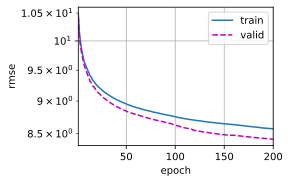

In [22]:
#线性模型
def get_net(in_features):
    net = nn.Sequential(nn.Linear(in_features,1))
    return net
k, num_epochs, lr, weight_decay, batch_size = 5, 200, 5, 0.001, 64

train_l, valid_l = k_fold(get_net,k, train_features, train_labels, num_epochs, lr,weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, 'f'平均验证log rmse: {float(valid_l):f}')

In [34]:
#非线性
def get_net(in_features):
    net = nn.Sequential(nn.Flatten(),
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    # nn.Linear(256, 128),
    # nn.ReLU(),
    # nn.Dropout(0.3),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 1))
    # ----------------------
    return net
k, num_epochs, lr, weight_decay, batch_size = 5, 200, 0.001, 0.001, 64

# train_l, valid_l = k_fold(get_net,k, train_features, train_labels, num_epochs, lr,weight_decay, batch_size)
# print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, 'f'平均验证log rmse: {float(valid_l):f}')

请注意，有时一组超参数的训练误差可能非常低，但$K$折交叉验证的误差要高得多，
这表明模型过拟合了。
在整个训练过程中，我们希望监控训练误差和验证误差这两个数字。
较少的过拟合可能表明现有数据可以支撑一个更强大的模型，
较大的过拟合可能意味着我们可以通过正则化技术来获益。

##  [**提交Kaggle预测**]

既然我们知道应该选择什么样的超参数，
我们不妨使用所有数据对其进行训练
（而不是仅使用交叉验证中使用的$1-1/K$的数据）。
然后，我们通过这种方式获得的模型可以应用于测试集。
将预测保存在CSV文件中可以简化将结果上传到Kaggle的过程。

如果测试集上的预测与 𝐾 倍交叉验证过程中的预测相似， 那就是时候把它们上传到Kaggle了。 下面的代码将生成一个名为submission.csv的文件。


训练log rmse：0.333229


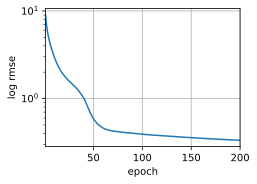

In [35]:
def train_and_pred(net,train_features, test_features, train_labels, test_data,num_epochs, lr, weight_decay, batch_size):

    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')

    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['Sold Price'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['Sold Price']], axis=1)
    submission.to_csv('california_submission_submit.csv', index=False)

net = get_net(train_features.shape[1])
train_and_pred(net,train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

接下来，如 :numref:`fig_kaggle_submit2`中所示，
我们可以提交预测到Kaggle上，并查看在测试集上的预测与实际房价（标签）的比较情况。
步骤非常简单。

* 登录Kaggle网站，访问房价预测竞赛页面。
* 点击“Submit Predictions”或“Late Submission”按钮（在撰写本文时，该按钮位于右侧）。
* 点击页面底部虚线框中的“Upload Submission File”按钮，选择要上传的预测文件。
* 点击页面底部的“Make Submission”按钮，即可查看结果。

![向Kaggle提交数据](https://github.com/AlvinScrp/d2l-zh-pytorch-colab/blob/master/img/kaggle-submit2.png?raw=1)
:width:`400px`
:label:`fig_kaggle_submit2`

## 小结

* 真实数据通常混合了不同的数据类型，需要进行预处理。
* 常用的预处理方法：将实值数据重新缩放为零均值和单位方法；用均值替换缺失值。
* 将类别特征转化为指标特征，可以使我们把这个特征当作一个独热向量来对待。
* 我们可以使用$K$折交叉验证来选择模型并调整超参数。
* 对数对于相对误差很有用。

## 练习

1. 把预测提交给Kaggle，它有多好？
1. 能通过直接最小化价格的对数来改进模型吗？如果试图预测价格的对数而不是价格，会发生什么？
1. 用平均值替换缺失值总是好主意吗？提示：能构造一个不随机丢失值的情况吗？
1. 通过$K$折交叉验证调整超参数，从而提高Kaggle的得分。
1. 通过改进模型（例如，层、权重衰减和dropout）来提高分数。
1. 如果我们没有像本节所做的那样标准化连续的数值特征，会发生什么？


[Discussions](https://discuss.d2l.ai/t/1824)
